#### Analytical Questions
Is the train dataset complete (has all the required dates)?
-   Which dates have the lowest and highest sales for each year (excluding days the store was closed)?
-  Compare the sales for each month across the years and determine which month of which year had the highest sales.
-  Did the earthquake impact sales?
-  Are certain stores or groups of stores selling more products? (Cluster, city, state, type)
-  Are sales affected by promotions, oil prices and holidays?
-  What  analysis can we get from the date and its extractable features?
-  Which product family and stores did the promotions affect.
-  What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)
-  Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.


In [1]:
# data manipulation
import pandas as pd
import numpy as np
import pyodbc
import statsmodels.api as sm
from dotenv import dotenv_values

# Suppress all warnings
import warnings

warnings.filterwarnings("ignore")

# Visualization

import matplotlib.pyplot as plt
import seaborn as sns 

#### Connect to server

In [2]:
# load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')

# Get the values for the credentials from .env file
database=environment_variables.get("databasename")
server=environment_variables.get("servername")
login=environment_variables.get("user")
password=environment_variables.get("password")

# create a connection string
connection_string=f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={login};PWD={password}"

In [3]:
#Connecting to the Server
connection = pyodbc.connect(connection_string)

#### Load datasets

In [4]:
# Loading dataset 1
first_data = pd.read_sql_query(
    "SELECT * FROM dbo.oil", connection)

first_data.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [5]:
first_data.shape

(1218, 2)

In [6]:
first_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [7]:
first_data.isna().sum()

date           0
dcoilwtico    43
dtype: int64

In [8]:
# Loading dataset 2
second_data = pd.read_sql_query(
    "SELECT * FROM dbo.holidays_events", connection)

second_data.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [9]:
second_data.shape

(350, 6)

In [10]:
second_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [11]:
# Loading dataset 3
third_data = pd.read_sql_query(
    "SELECT * FROM dbo.stores", connection)

third_data.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [12]:
third_data.shape

(54, 5)

In [13]:
third_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


### load train_data

In [14]:
train_data = pd.read_csv("C:\\Users\\HP ELITEBOOK 830 G5\\Desktop\\Home Office\\Azubi Project\\Sales-Forecasting-Times-Series-Analysis\\data\\train.csv")

train_data

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [15]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [16]:
train_data.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

### load transaction data

In [17]:
transaction_data = pd.read_csv('C:\\Users\\HP ELITEBOOK 830 G5\\Desktop\\Home Office\\Azubi Project\\Sales-Forecasting-Times-Series-Analysis\\data\\transactions.csv')

transaction_data

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


In [18]:
transaction_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


In [19]:
transaction_data.isna().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

#### Merge first_data & second_data on date column (common column)

In [20]:
#mt1 implies firstmerge (oil data and holidays data)
mt1 = pd.merge(first_data, second_data, on='date')

mt1

,date,dcoilwtico,type,locale,locale_name,description,transferred
0,2013-01-01,NaN,Holiday,National,Ecuador,Primer dia del ano,False
1,2013-02-11,97.010002,Holiday,National,Ecuador,Carnaval,False
2,2013-02-12,97.480003,Holiday,National,Ecuador,Carnaval,False
3,2013-04-01,97.099998,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
4,2013-04-12,91.230003,Holiday,Local,Cuenca,Fundacion de Cuenca,False
...,...,...,...,...,...,...,...
197,2017-07-25,47.770000,Additional,Local,Guayaquil,Fundacion de Guayaquil,False
198,2017-08-10,48.540001,Holiday,National,Ecuador,Primer Grito de Independencia,True
199,2017-08-11,48.810001,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False
200,2017-08-15,47.570000,Holiday,Local,Riobamba,Fundacion de Riobamba,False


#### Check for mt1 info

In [21]:
mt1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202 entries, 0 to 201
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         202 non-null    object 
 1   dcoilwtico   182 non-null    float64
 2   type         202 non-null    object 
 3   locale       202 non-null    object 
 4   locale_name  202 non-null    object 
 5   description  202 non-null    object 
 6   transferred  202 non-null    bool   
dtypes: bool(1), float64(1), object(5)
memory usage: 9.8+ KB


In [22]:
# Check missing values
mt1.isna().sum()

date            0
dcoilwtico     20
type            0
locale          0
locale_name     0
description     0
transferred     0
dtype: int64

### Secong merged data mt2 (mt1 and train_data) on data column

In [23]:
mt2=pd.merge(mt1, train_data, on='date')

mt2

,date,dcoilwtico,type,locale,locale_name,description,transferred,id,store_nbr,family,sales,onpromotion
0,2013-01-01,NaN,Holiday,National,Ecuador,Primer dia del ano,False,0,1,AUTOMOTIVE,0.000,0
1,2013-01-01,NaN,Holiday,National,Ecuador,Primer dia del ano,False,1,1,BABY CARE,0.000,0
2,2013-01-01,NaN,Holiday,National,Ecuador,Primer dia del ano,False,2,1,BEAUTY,0.000,0
3,2013-01-01,NaN,Holiday,National,Ecuador,Primer dia del ano,False,3,1,BEVERAGES,0.000,0
4,2013-01-01,NaN,Holiday,National,Ecuador,Primer dia del ano,False,4,1,BOOKS,0.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
352831,2017-08-15,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,3000883,9,POULTRY,438.133,0
352832,2017-08-15,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,3000884,9,PREPARED FOODS,154.553,1
352833,2017-08-15,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,3000885,9,PRODUCE,2419.729,148
352834,2017-08-15,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,3000886,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [24]:
mt2.duplicated().sum()

np.int64(0)

In [25]:
mt2.isna().sum()

date               0
dcoilwtico     30294
type               0
locale             0
locale_name        0
description        0
transferred        0
id                 0
store_nbr          0
family             0
sales              0
onpromotion        0
dtype: int64

### third merge mt3 (inner join mt2 with third_data) on 'store_nbr'

In [26]:
mt3= pd.merge(mt2,third_data,on= 'store_nbr', how='inner')

mt3

,date,dcoilwtico,type_x,locale,locale_name,description,transferred,id,store_nbr,family,sales,onpromotion,city,state,type_y,cluster
0,2013-01-01,NaN,Holiday,National,Ecuador,Primer dia del ano,False,0,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D,13
1,2013-01-01,NaN,Holiday,National,Ecuador,Primer dia del ano,False,1,1,BABY CARE,0.000,0,Quito,Pichincha,D,13
2,2013-01-01,NaN,Holiday,National,Ecuador,Primer dia del ano,False,2,1,BEAUTY,0.000,0,Quito,Pichincha,D,13
3,2013-01-01,NaN,Holiday,National,Ecuador,Primer dia del ano,False,3,1,BEVERAGES,0.000,0,Quito,Pichincha,D,13
4,2013-01-01,NaN,Holiday,National,Ecuador,Primer dia del ano,False,4,1,BOOKS,0.000,0,Quito,Pichincha,D,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352831,2017-08-15,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,3000883,9,POULTRY,438.133,0,Quito,Pichincha,B,6
352832,2017-08-15,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,3000884,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6
352833,2017-08-15,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,3000885,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6
352834,2017-08-15,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,3000886,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6


In [27]:
mt3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352836 entries, 0 to 352835
Data columns (total 16 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   date         352836 non-null  object 
 1   dcoilwtico   322542 non-null  float64
 2   type_x       352836 non-null  object 
 3   locale       352836 non-null  object 
 4   locale_name  352836 non-null  object 
 5   description  352836 non-null  object 
 6   transferred  352836 non-null  bool   
 7   id           352836 non-null  int64  
 8   store_nbr    352836 non-null  int64  
 9   family       352836 non-null  object 
 10  sales        352836 non-null  float64
 11  onpromotion  352836 non-null  int64  
 12  city         352836 non-null  object 
 13  state        352836 non-null  object 
 14  type_y       352836 non-null  object 
 15  cluster      352836 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(9)
memory usage: 40.7+ MB


In [28]:
mt3.isnull().sum()

date               0
dcoilwtico     30294
type_x             0
locale             0
locale_name        0
description        0
transferred        0
id                 0
store_nbr          0
family             0
sales              0
onpromotion        0
city               0
state              0
type_y             0
cluster            0
dtype: int64

#### fourth merge mt4 (inner join mt3 with transaction_data ON ['date' , 'store_nbr'] )

In [29]:
mt4=pd.merge(mt3,transaction_data, on= ['date' , 'store_nbr'] ,  how='inner')

mt4

,date,dcoilwtico,type_x,locale,locale_name,description,transferred,id,store_nbr,family,sales,onpromotion,city,state,type_y,cluster,transactions
0,2013-01-01,NaN,Holiday,National,Ecuador,Primer dia del ano,False,561,25,AUTOMOTIVE,0.000,0,Salinas,Santa Elena,D,1,770
1,2013-01-01,NaN,Holiday,National,Ecuador,Primer dia del ano,False,562,25,BABY CARE,0.000,0,Salinas,Santa Elena,D,1,770
2,2013-01-01,NaN,Holiday,National,Ecuador,Primer dia del ano,False,563,25,BEAUTY,2.000,0,Salinas,Santa Elena,D,1,770
3,2013-01-01,NaN,Holiday,National,Ecuador,Primer dia del ano,False,564,25,BEVERAGES,810.000,0,Salinas,Santa Elena,D,1,770
4,2013-01-01,NaN,Holiday,National,Ecuador,Primer dia del ano,False,565,25,BOOKS,0.000,0,Salinas,Santa Elena,D,1,770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322042,2017-08-15,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,3000883,9,POULTRY,438.133,0,Quito,Pichincha,B,6,2155
322043,2017-08-15,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,3000884,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,2155
322044,2017-08-15,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,3000885,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,2155
322045,2017-08-15,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,3000886,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6,2155


In [30]:
mt4.duplicated().sum()

np.int64(0)

In [31]:
mt4.isnull().sum()

date                0
dcoilwtico      22044
type_x              0
locale              0
locale_name         0
description         0
transferred         0
id                  0
store_nbr           0
family              0
sales               0
onpromotion         0
city                0
state               0
type_y              0
cluster             0
transactions        0
dtype: int64

In [32]:
mt4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322047 entries, 0 to 322046
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   date          322047 non-null  object 
 1   dcoilwtico    300003 non-null  float64
 2   type_x        322047 non-null  object 
 3   locale        322047 non-null  object 
 4   locale_name   322047 non-null  object 
 5   description   322047 non-null  object 
 6   transferred   322047 non-null  bool   
 7   id            322047 non-null  int64  
 8   store_nbr     322047 non-null  int64  
 9   family        322047 non-null  object 
 10  sales         322047 non-null  float64
 11  onpromotion   322047 non-null  int64  
 12  city          322047 non-null  object 
 13  state         322047 non-null  object 
 14  type_y        322047 non-null  object 
 15  cluster       322047 non-null  int64  
 16  transactions  322047 non-null  int64  
dtypes: bool(1), float64(2), int64(5), object(9)
memo

In [33]:
mt4.describe().T

,count,mean,std,min,25%,50%,75%,max
dcoilwtico,300003.0,6.407791e+01,25.147682,27.959999,44.66,5.144000e+01,9.474000e+01,1.079500e+02
id,322047.0,1.682979e+06,786249.257767,561.000000,1010616.50,1.842406e+06,2.209556e+06,3.000887e+06
store_nbr,322047.0,2.699467e+01,15.595174,1.000000,13.00,2.700000e+01,4.000000e+01,5.400000e+01
sales,322047.0,4.063835e+02,1246.881240,0.000000,1.00,1.900000e+01,2.412605e+02,1.247170e+05
onpromotion,322047.0,3.727136e+00,15.512095,0.000000,0.00,0.000000e+00,1.000000e+00,7.160000e+02
cluster,322047.0,8.531202e+00,4.713809,1.000000,4.00,9.000000e+00,1.300000e+01,1.700000e+01
transactions,322047.0,1.734118e+03,1050.335018,54.000000,1030.00,1.409000e+03,2.148000e+03,8.359000e+03


### Convert date to right dtype

In [34]:
# Converting date into datetime

mt4['date'] = pd.to_datetime(mt4['date'])
mt4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322047 entries, 0 to 322046
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          322047 non-null  datetime64[ns]
 1   dcoilwtico    300003 non-null  float64       
 2   type_x        322047 non-null  object        
 3   locale        322047 non-null  object        
 4   locale_name   322047 non-null  object        
 5   description   322047 non-null  object        
 6   transferred   322047 non-null  bool          
 7   id            322047 non-null  int64         
 8   store_nbr     322047 non-null  int64         
 9   family        322047 non-null  object        
 10  sales         322047 non-null  float64       
 11  onpromotion   322047 non-null  int64         
 12  city          322047 non-null  object        
 13  state         322047 non-null  object        
 14  type_y        322047 non-null  object        
 15  cluster       322

In [35]:
# Create a Copy of the original dataframe
df_copy = mt4.copy()

# Add more datetime features to the new dataframe. 
mt4['year'] = mt4['date'].dt.year
mt4['month'] = mt4['date'].dt.month
mt4['day'] = mt4['date'].dt.day

# Replace the numeric month and day with their actual names
mt4['month_name'] = mt4['date'].dt.strftime('%B')  # Full month name
mt4['day_name'] = mt4['date'].dt.strftime('%A')    # Full day name

# Check the first few rows of the new dataframe to verify the changes
mt4.head()


,date,dcoilwtico,type_x,locale,locale_name,description,transferred,id,store_nbr,family,...,city,state,type_y,cluster,transactions,year,month,day,month_name,day_name
0,2013-01-01,NaN,Holiday,National,Ecuador,Primer dia del ano,False,561,25,AUTOMOTIVE,...,Salinas,Santa Elena,D,1,770,2013,1,1,January,Tuesday
1,2013-01-01,NaN,Holiday,National,Ecuador,Primer dia del ano,False,562,25,BABY CARE,...,Salinas,Santa Elena,D,1,770,2013,1,1,January,Tuesday
2,2013-01-01,NaN,Holiday,National,Ecuador,Primer dia del ano,False,563,25,BEAUTY,...,Salinas,Santa Elena,D,1,770,2013,1,1,January,Tuesday
3,2013-01-01,NaN,Holiday,National,Ecuador,Primer dia del ano,False,564,25,BEVERAGES,...,Salinas,Santa Elena,D,1,770,2013,1,1,January,Tuesday
4,2013-01-01,NaN,Holiday,National,Ecuador,Primer dia del ano,False,565,25,BOOKS,...,Salinas,Santa Elena,D,1,770,2013,1,1,January,Tuesday


In [36]:
# Lets Change some Column names.
mt4.rename(columns={'locale':'store_marketscope', 
                    'locale_name':'store_location', 
                    'type_x':'Holiday_type',
                    'type_y':'store_type',
                    'dcoilwtico':'oil_price'}, inplace=True)
mt4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322047 entries, 0 to 322046
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   date               322047 non-null  datetime64[ns]
 1   oil_price          300003 non-null  float64       
 2   Holiday_type       322047 non-null  object        
 3   store_marketscope  322047 non-null  object        
 4   store_location     322047 non-null  object        
 5   description        322047 non-null  object        
 6   transferred        322047 non-null  bool          
 7   id                 322047 non-null  int64         
 8   store_nbr          322047 non-null  int64         
 9   family             322047 non-null  object        
 10  sales              322047 non-null  float64       
 11  onpromotion        322047 non-null  int64         
 12  city               322047 non-null  object        
 13  state              322047 non-null  object  

In [37]:
# Generate a Summary statistics for The numerical columns

mt4.select_dtypes(include=['float64', 'int64']).describe().T

,count,mean,std,min,25%,50%,75%,max
oil_price,300003.0,6.407791e+01,25.147682,27.959999,44.66,5.144000e+01,9.474000e+01,1.079500e+02
id,322047.0,1.682979e+06,786249.257767,561.000000,1010616.50,1.842406e+06,2.209556e+06,3.000887e+06
store_nbr,322047.0,2.699467e+01,15.595174,1.000000,13.00,2.700000e+01,4.000000e+01,5.400000e+01
sales,322047.0,4.063835e+02,1246.881240,0.000000,1.00,1.900000e+01,2.412605e+02,1.247170e+05
onpromotion,322047.0,3.727136e+00,15.512095,0.000000,0.00,0.000000e+00,1.000000e+00,7.160000e+02
cluster,322047.0,8.531202e+00,4.713809,1.000000,4.00,9.000000e+00,1.300000e+01,1.700000e+01
transactions,322047.0,1.734118e+03,1050.335018,54.000000,1030.00,1.409000e+03,2.148000e+03,8.359000e+03


Inference on Descrptive Statistics
- The mean **oil price** is approximately $64.08, with a standard deviation of $25.15.
- The **sales** data shows a high variability, with a mean of 406.38 and a standard deviation of 1246.88. The median sales value is much lower at 19, indicating a skewed distribution.
-  **Store numbers** range from 1 to 54, with a mean of 26.99.
-  **The "onpromotion"** feature has a median of 0, indicating that many entries have no promotions. 
- **Transaction** counts range widely, with a mean of 1734.12 and a median of 1409, suggesting some stores have significantly higher activity.

In [38]:
# generate a Summary statistics for categorical columns.

mt4.select_dtypes(include=['object','bool']).describe().T

,count,unique,top,freq
Holiday_type,322047,5,Holiday,202818
store_marketscope,322047,3,National,160710
store_location,322047,24,Ecuador,160710
description,322047,80,Carnaval,16368
transferred,322047,2,False,308352
family,322047,33,AUTOMOTIVE,9759
city,322047,22,Quito,112266
state,322047,16,Pichincha,118668
store_type,322047,5,D,110121
month_name,322047,12,December,51381


In [39]:
# Check the unique values in each column

mt4.select_dtypes(include=['object','bool']).nunique()

Holiday_type          5
store_marketscope     3
store_location       24
description          80
transferred           2
family               33
city                 22
state                16
store_type            5
month_name           12
day_name              5
dtype: int64

In [40]:
unique_values = mt4.select_dtypes(include=['object', 'bool']).apply(pd.Series.unique)
unique_values

Holiday_type            [Holiday, Additional, Transfer, Event, Bridge]
store_marketscope                          [National, Regional, Local]
store_location       [Ecuador, Cotopaxi, Cuenca, Imbabura, Machala,...
description          [Primer dia del ano, Carnaval, Provincializaci...
transferred                                              [False, True]
family               [AUTOMOTIVE, BABY CARE, BEAUTY, BEVERAGES, BOO...
city                 [Salinas, Quito, Cayambe, Latacunga, Riobamba,...
state                [Santa Elena, Pichincha, Cotopaxi, Chimborazo,...
store_type                                             [D, C, B, E, A]
month_name           [January, February, April, May, June, July, Au...
day_name                [Tuesday, Monday, Friday, Wednesday, Thursday]
dtype: object

In [41]:
#Show all the unique values in the store_location table

unique_values['store_location']

array(['Ecuador', 'Cotopaxi', 'Cuenca', 'Imbabura', 'Machala',
       'Latacunga', 'El Carmen', 'Santo Domingo', 'Cayambe', 'Guayaquil',
       'Esmeraldas', 'Riobamba', 'Quevedo',
       'Santo Domingo de los Tsachilas', 'Santa Elena', 'Ambato', 'Quito',
       'Libertad', 'Puyo', 'Guaranda', 'Loja', 'Salinas', 'Manta',
       'Ibarra'], dtype=object)

In [42]:
# Check the null values in the 'dcoilwtico' column if they are holidays
null_values_table1 = mt4[mt4['oil_price'].isnull()]
null_values_table1

,date,oil_price,Holiday_type,store_marketscope,store_location,description,transferred,id,store_nbr,family,...,city,state,store_type,cluster,transactions,year,month,day,month_name,day_name
0,2013-01-01,NaN,Holiday,National,Ecuador,Primer dia del ano,False,561,25,AUTOMOTIVE,...,Salinas,Santa Elena,D,1,770,2013,1,1,January,Tuesday
1,2013-01-01,NaN,Holiday,National,Ecuador,Primer dia del ano,False,562,25,BABY CARE,...,Salinas,Santa Elena,D,1,770,2013,1,1,January,Tuesday
2,2013-01-01,NaN,Holiday,National,Ecuador,Primer dia del ano,False,563,25,BEAUTY,...,Salinas,Santa Elena,D,1,770,2013,1,1,January,Tuesday
3,2013-01-01,NaN,Holiday,National,Ecuador,Primer dia del ano,False,564,25,BEVERAGES,...,Salinas,Santa Elena,D,1,770,2013,1,1,January,Tuesday
4,2013-01-01,NaN,Holiday,National,Ecuador,Primer dia del ano,False,565,25,BOOKS,...,Salinas,Santa Elena,D,1,770,2013,1,1,January,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313132,2017-07-03,NaN,Holiday,Local,Santo Domingo,Fundacion de Santo Domingo,False,2924257,9,POULTRY,...,Quito,Pichincha,B,6,2224,2017,7,3,July,Monday
313133,2017-07-03,NaN,Holiday,Local,Santo Domingo,Fundacion de Santo Domingo,False,2924258,9,PREPARED FOODS,...,Quito,Pichincha,B,6,2224,2017,7,3,July,Monday
313134,2017-07-03,NaN,Holiday,Local,Santo Domingo,Fundacion de Santo Domingo,False,2924259,9,PRODUCE,...,Quito,Pichincha,B,6,2224,2017,7,3,July,Monday
313135,2017-07-03,NaN,Holiday,Local,Santo Domingo,Fundacion de Santo Domingo,False,2924260,9,SCHOOL AND OFFICE SUPPLIES,...,Quito,Pichincha,B,6,2224,2017,7,3,July,Monday


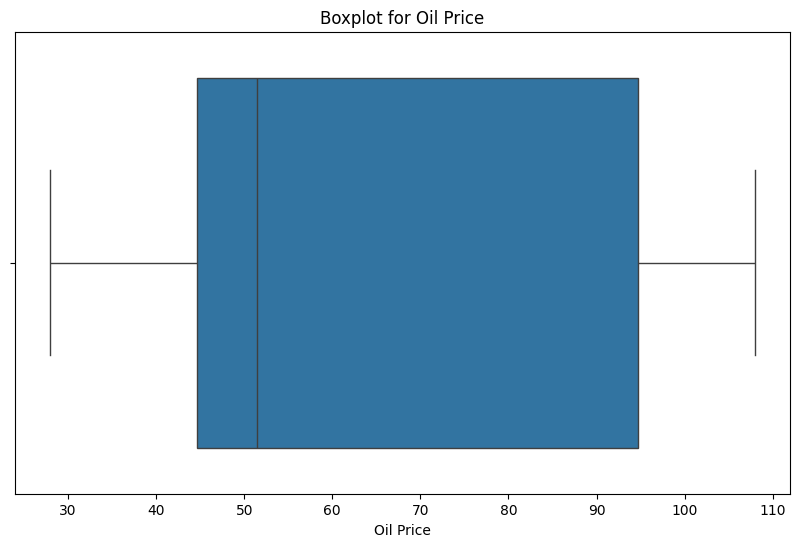

In [43]:
# Create a Boxplot for the "oil_price" column
plt.figure(figsize=(10,6))

sns.boxplot(x=mt4['oil_price'])
# Add Title and Labels

plt.title("Boxplot for Oil Price")
plt.xlabel("Oil Price")
plt.show()

**Inference=**
There are no outliers in the boxplot above
We could impute the mean using the simpleimputer or check for other methods feasible of handling the mising data here. 

### Univariate Analysis

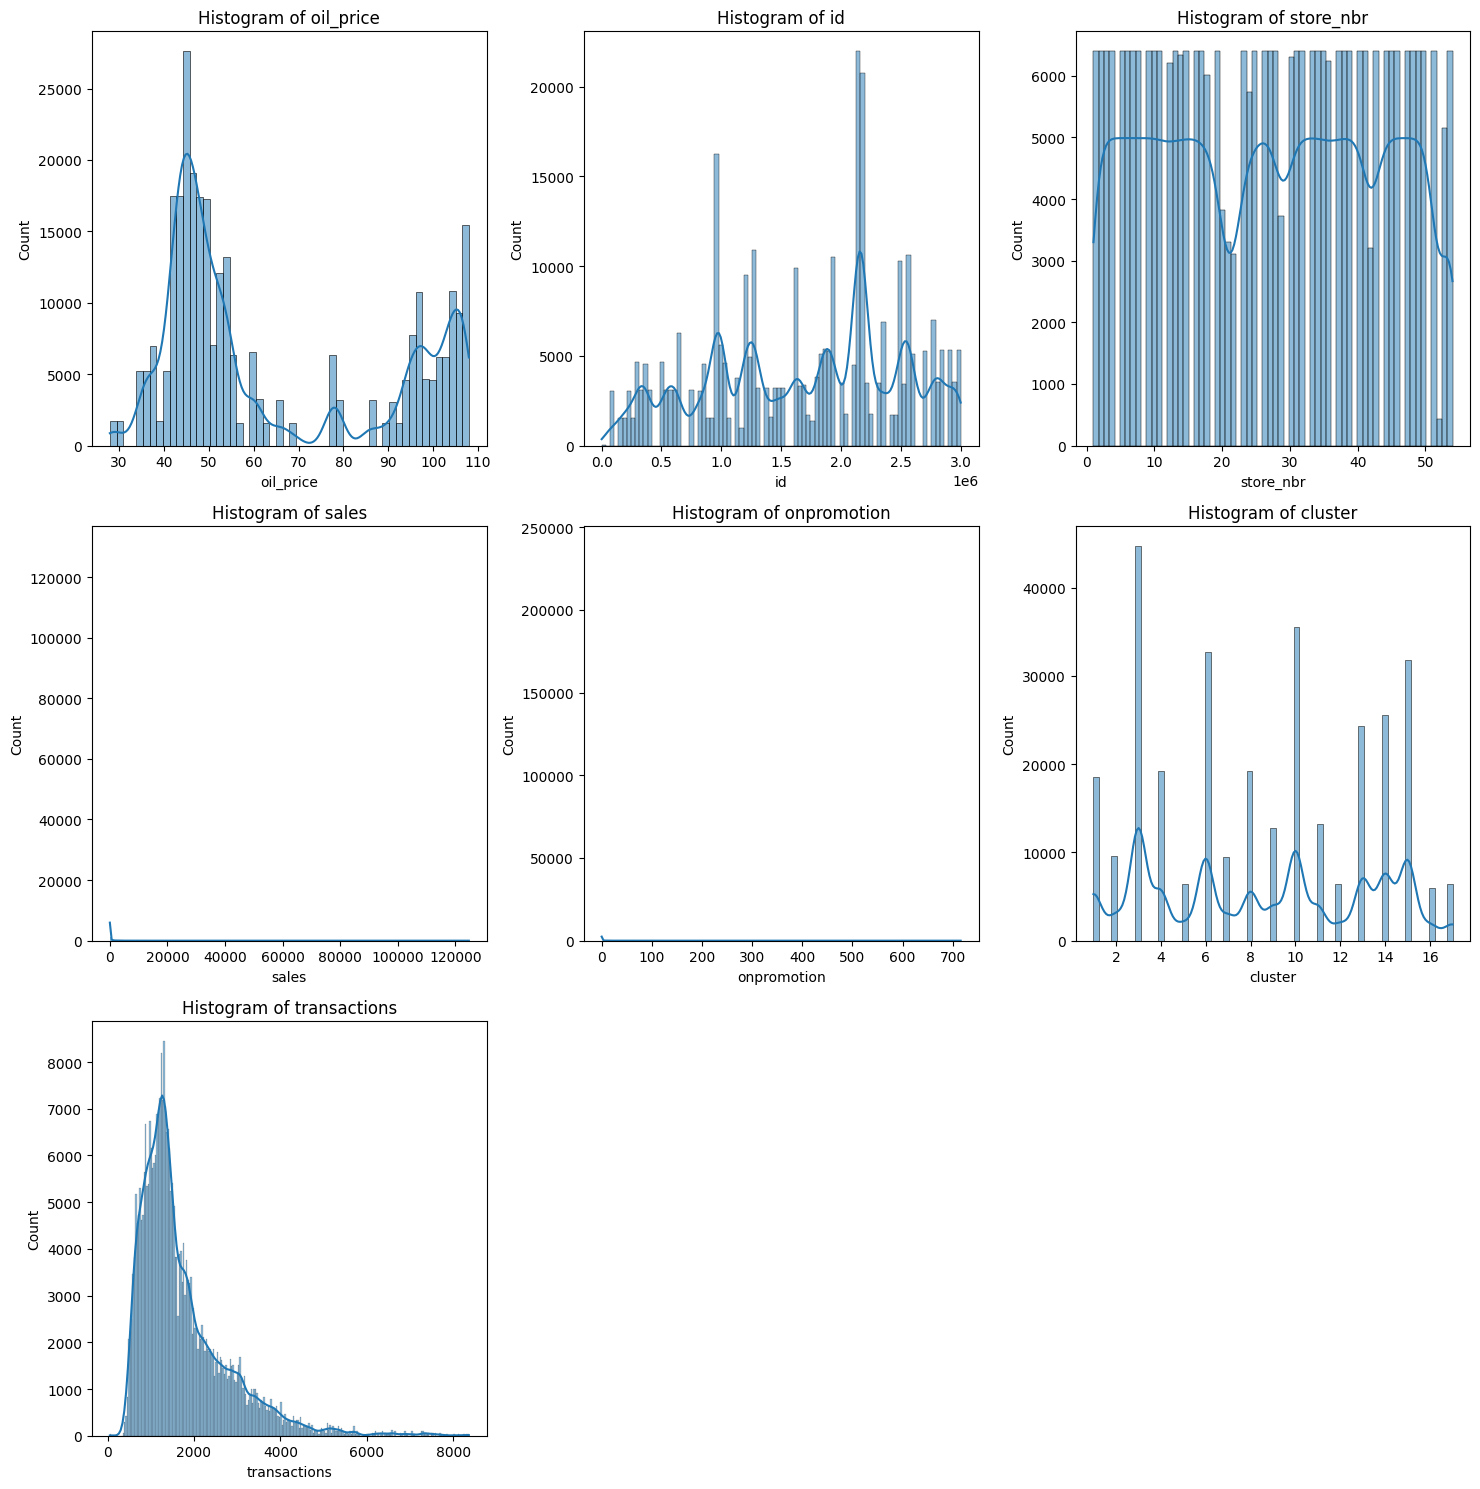

In [44]:
# Perform a univariate analysis on the data

# Create a histogram of the  numeric values each.

numeric_columns = mt4.select_dtypes(include=['float64', 'int64']).columns

# Calculate the number of rows needed for the subplots
n_cols = 3
n_rows = -(-len(numeric_columns) // n_cols)  # Ceiling division

# Create subplots
plt.figure(figsize=(15, 5 * n_rows))
for i, column in enumerate(numeric_columns):
    plt.subplot(n_rows, n_cols, i+1)
    sns.histplot(mt4[column], kde=True)
    plt.title(f'Histogram of {column}')

plt.tight_layout()
plt.show()


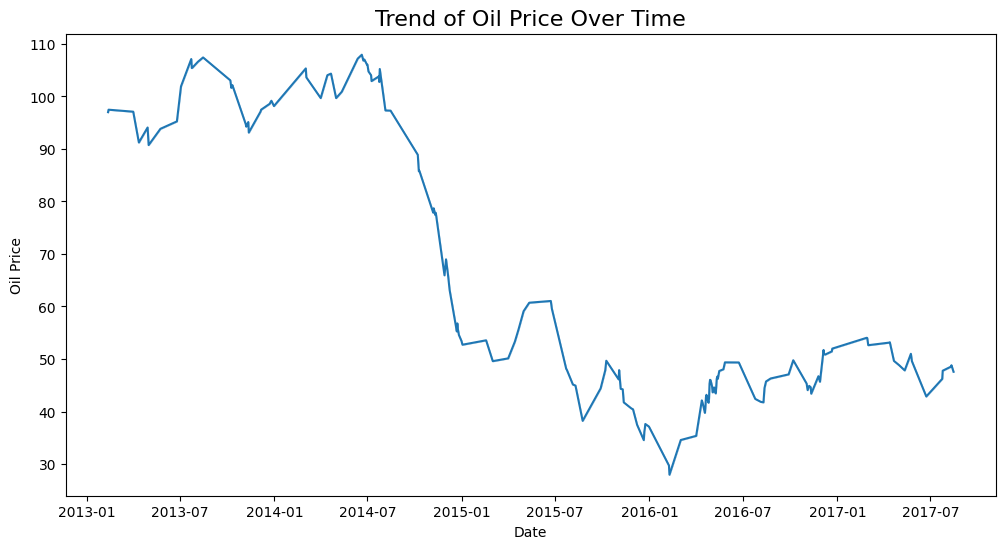

In [45]:
# Lets plot the trend of oil Prices over time using a lineplot

plt.figure(figsize=(12,6))

sns.lineplot(x='date', y='oil_price', data=mt4)
plt.title("Trend of Oil Price Over Time", fontsize=(16) )
plt.xlabel("Date")
plt.ylabel("Oil Price")
plt.show()

**Inference**

The graph shows the trend of oil prices from January 2013 to July 2017.

1. **Initial Stability and Increase**: From early 2013 to mid-2014, oil prices were relatively stable, fluctuating around $90 to $110.

2. **Significant Decline**: Starting from mid-2014, there is a sharp decline in oil prices. By early 2016, prices dropped to around $30 to $40, marking a significant decrease.

3. **Gradual Recovery**: After early 2016, there is a gradual recovery with fluctuations. Prices start to increase slowly, reaching around $50 by mid-2017.

4. **Volatility**: Throughout the period, especially during the recovery phase, there are noticeable fluctuations, indicating a volatile oil market.

The significant drop in oil prices around mid-2014 to early 2016 could be attributed to various global economic factors, including changes in supply and demand, geopolitical events, and market speculation. The gradual recovery suggests stabilization efforts and adjustments in the market dynamics. 

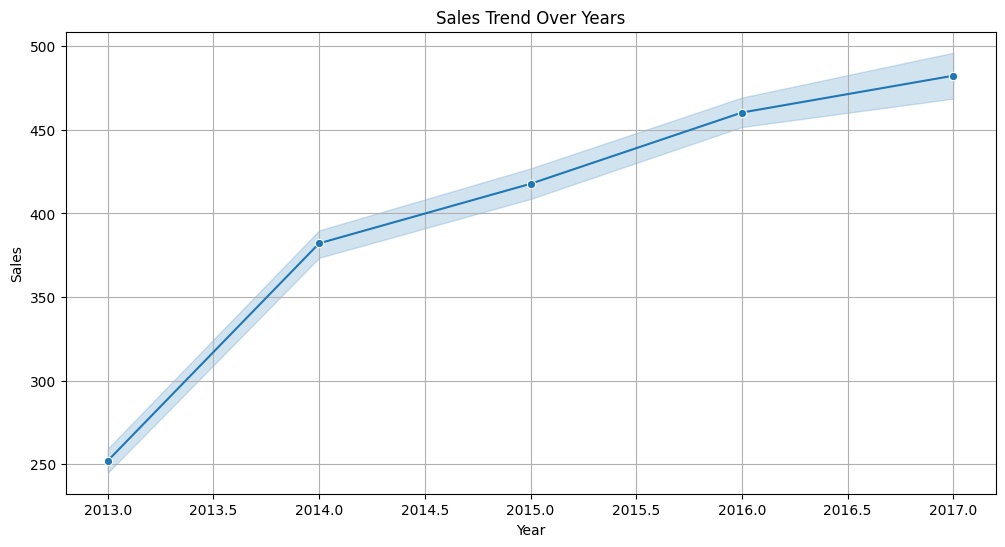

In [46]:
# Analysis of Sales over Years
plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='sales', data=mt4, marker='o')
plt.title('Sales Trend Over Years')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

**Insights**

- Upward Trend: There is a clear upward trend in sales from 2013 to 2017. Sales increased consistently every year.

- Growth Rate:
2013 to 2014: The most significant growth occurred between 2013 and 2014, where sales jumped from around 250 to approximately 400.
2014 to 2017: From 2014 to 2017, sales continued to increase but at a more gradual and steady rate.

- Consistency: The shaded area around the line indicates the confidence interval, showing the variability of sales data. The confidence interval is relatively narrow, suggesting that the sales data is consistent and the trend is reliable.

- The consistent increase in sales suggests strong business performance and possibly effective strategies in place.
- Future Expectations: If the trend continues, it is reasonable to expect further sales growth in subsequent years.

**In summary, the trend indicates a positive and consistent increase in sales from 2013 to 2017, with the most substantial growth occurring in the early years of this period.**



### Multivariate Analysis 

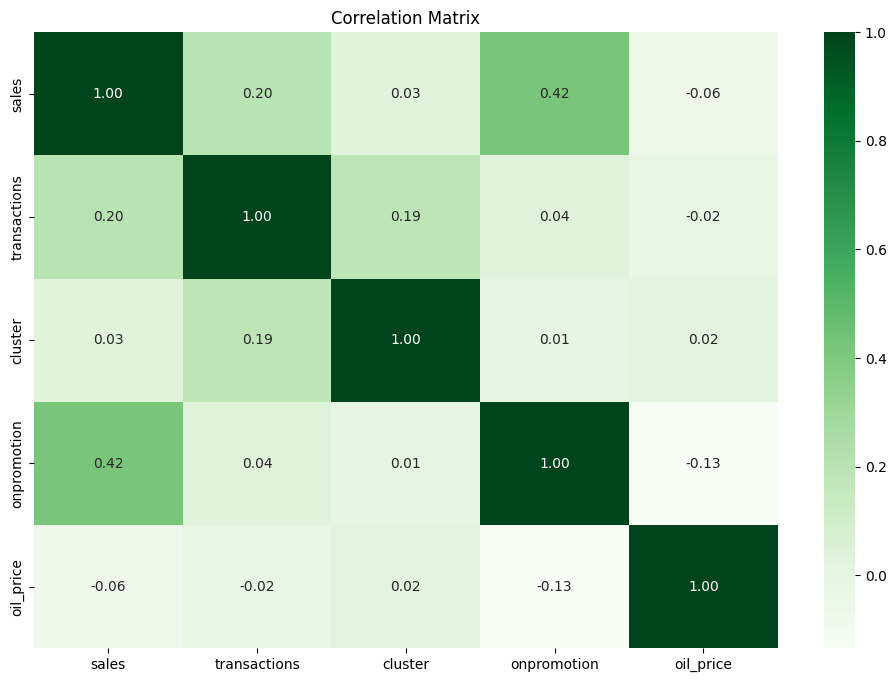

In [47]:
# Define the columns to include in the correlation analysis
multivariate_columns = ['sales', 'transactions', 'cluster', 'onpromotion',"oil_price"]
# Calculate the correlation matrix
corr = mt4[multivariate_columns].corr()

# Plot a heatmap for the correlation matrix
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(data=corr, annot=True, cmap='Greens', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

- Inference

1. **Sales and On Promotion**: There is a moderate positive correlation (0.42) between sales and onpromotion, indicating that promotions are likely boosting sales.
2. **Sales and Transactions**: A positive correlation (0.20) exists between sales and transactions, suggesting that more transactions generally lead to higher sales.
3. **Sales and Oil Price**: A slight negative correlation (-0.06) between sales and oil price suggests that higher oil prices might slightly impact sales negatively.
4. **Transactions and Cluster**: There is a weak positive correlation (0.19) between transactions and cluster, implying minor variability in transactions across different clusters.
5. **On Promotion and Oil Price**: A weak negative correlation (-0.13) between onpromotion and oil price indicates that higher oil prices slightly reduce the effect of promotions.

count    322047.000000
mean        406.383452
std        1246.881240
min           0.000000
25%           1.000000
50%          19.000000
75%         241.260505
max      124717.000000
Name: sales, dtype: float64


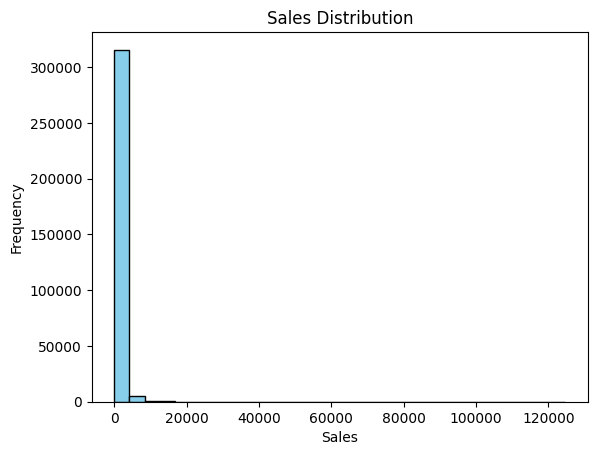

In [48]:
sales_desc = mt4['sales'].describe()
print(sales_desc)

# Histogram
plt.hist(mt4['sales'], bins=30, color='skyblue', edgecolor='black')
plt.title('Sales Distribution')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()


In [49]:
# Calculate frequency and percentage
store_type_counts = mt4['store_type'].value_counts()
store_type_percent = store_type_counts / store_type_counts.sum() * 100

# Create a DataFrame for plotting
store_type_df = pd.DataFrame({'Count': store_type_counts, 'Percentage': store_type_percent})
store_type_df

,Count,Percentage
store_type,,
D,110121,34.194077
C,92367,28.681217
A,51645,16.036479
B,45144,14.017830
E,22770,7.070397


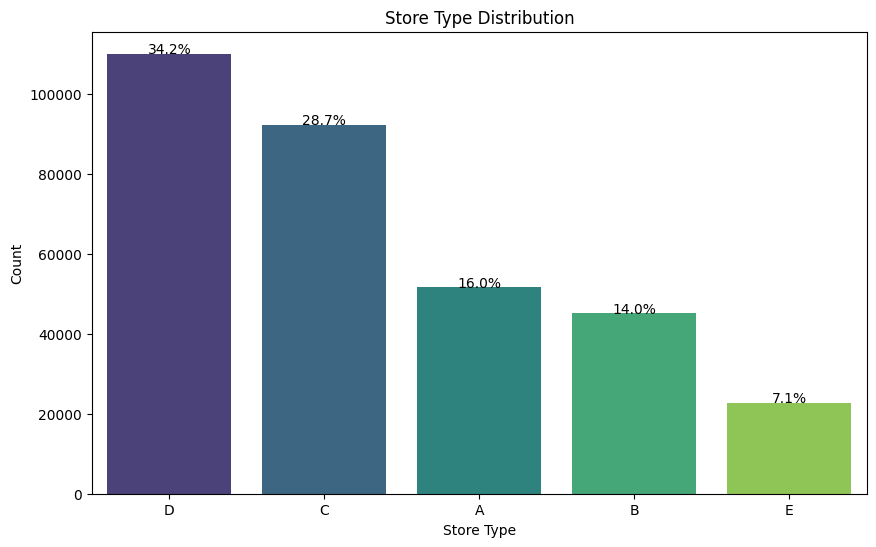

In [50]:
# Plotting
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=store_type_df.index, y=store_type_df['Count'], palette='viridis')

# Annotate with percentages
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3,
            '{:1.1f}%'.format(height / store_type_counts.sum() * 100),
            ha="center")

plt.title('Store Type Distribution')
plt.xlabel('Store Type')
plt.ylabel('Count')
plt.show()

#### Answering Analytical Questions
Is the train dataset complete (has all the required dates)?
-   Which dates have the lowest and highest sales for each year (excluding days the store was closed)?
-  Compare the sales for each month across the years and determine which month of which year had the highest sales.
-  Did the earthquake impact sales?
-  Are certain stores or groups of stores selling more products? (Cluster, city, state, type)
-  Are sales affected by promotions, oil prices and holidays?
-  What  analysis can we get from the date and its extractable features?
-  Which product family and stores did the promotions affect.
-  What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)
-  Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.


**Q2. Which dates have the lowest and highest sales for each year (excluding days the store was closed)?**

In [52]:
# Filter out days when the store was closed
open_store_df = mt4[mt4['sales'] > 0]

# Group by year and find the date with the lowest and highest sales
lowest_sales_dates = open_store_df.loc[open_store_df.groupby('year')['sales'].idxmin()]
highest_sales_dates = open_store_df.loc[open_store_df.groupby('year')['sales'].idxmax()]

# Print results
print("Dates with the lowest sales for each year:")
print(lowest_sales_dates[['date', 'year', 'sales']])

print("\nDates with the highest sales for each year:")
print(highest_sales_dates[['date', 'year', 'sales']])

Dates with the lowest sales for each year:
             date  year  sales
19370  2013-07-23  2013  0.294
106490 2014-12-05  2014  0.188
152987 2015-08-24  2015  0.300
242285 2016-06-23  2016  0.396
301289 2017-05-01  2017  0.470

Dates with the highest sales for each year:
             date  year     sales
36510  2013-11-12  2013   46271.0
107922 2014-12-08  2014   45361.0
166827 2015-11-11  2015   33274.0
217548 2016-05-02  2016  124717.0
286221 2017-01-02  2017   23966.0


**Q3. Compare the sales for each month across the years and determine which month of which year had the highest sales.**

The highest sales were in 2016-April: $11797704.02


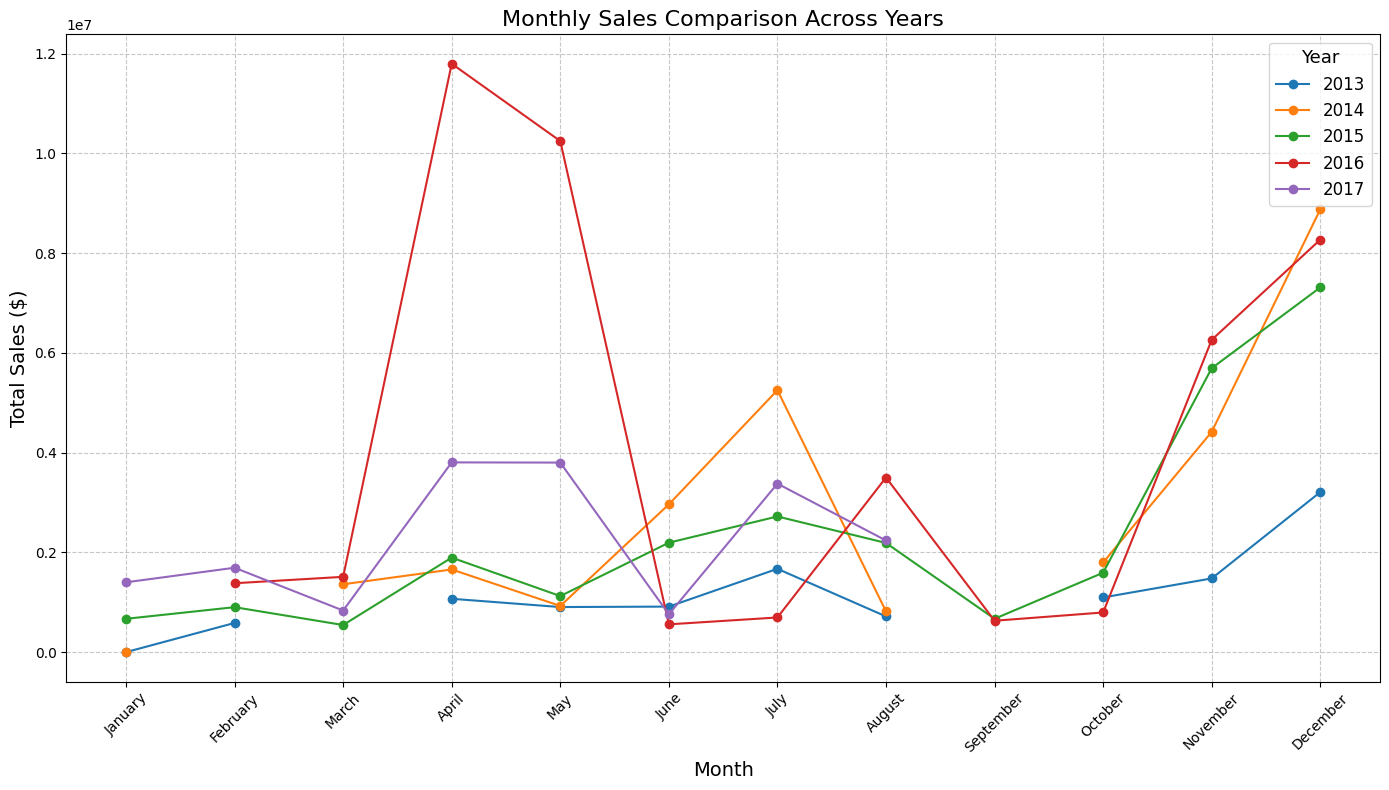

In [55]:

# Group by year and month to get the total sales for each month of each year
monthly_sales = mt4.groupby(['year', 'month_name'])['sales'].sum().reset_index()

# Determine the month and year with the highest sales
highest_sales = monthly_sales.loc[monthly_sales['sales'].idxmax()]

# Print the highest sales information
print(f"The highest sales were in {highest_sales['year']}-{highest_sales['month_name']}: ${highest_sales['sales']:.2f}")

# Pivot the data to have years as columns and months as rows for better visualization
monthly_sales_pivot = monthly_sales.pivot(index='month_name', columns='year', values='sales')

# Sort the index to ensure months are in order
monthly_sales_pivot = monthly_sales_pivot.reindex(
    ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
)

# Plot the data
plt.figure(figsize=(14, 8))

# Line plot for each year
for year in monthly_sales_pivot.columns:
    plt.plot(monthly_sales_pivot.index, monthly_sales_pivot[year], marker='o', label=year)

# Add plot titles and labels
plt.title('Monthly Sales Comparison Across Years', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Total Sales ($)', fontsize=14)
plt.legend(title='Year', title_fontsize='13', fontsize='12')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to fit labels

# Show the plot
plt.show()


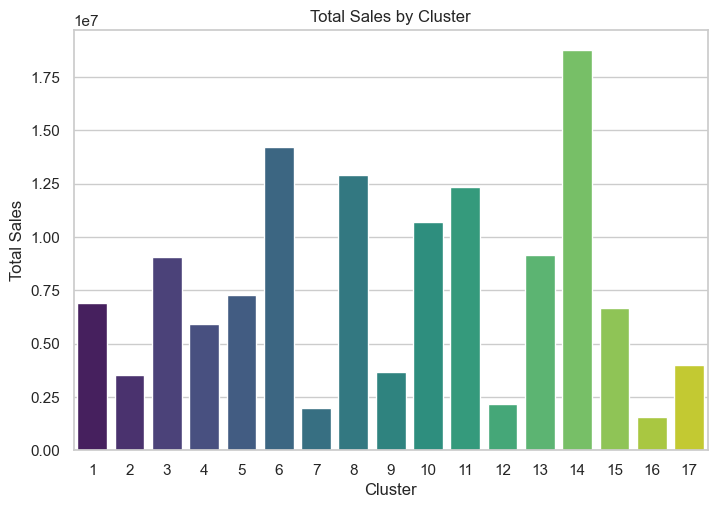

In [58]:
# Group by Cluster, City, State, and Type and calculate total sales
grouped_sales_cluster = mt4.groupby('cluster')['sales'].sum().reset_index()
grouped_sales_city = mt4.groupby('city')['sales'].sum().reset_index()
grouped_sales_state = mt4.groupby('state')['sales'].sum().reset_index()
grouped_sales_type = mt4.groupby('store_type')['sales'].sum().reset_index()

# Set up the figure
plt.figure(figsize=(18, 12))

# Plot sales by cluster
plt.subplot(2, 2, 1)
sns.barplot(data=grouped_sales_cluster, x='cluster', y='sales', palette='viridis')
plt.title('Total Sales by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Total Sales')
plt.show()

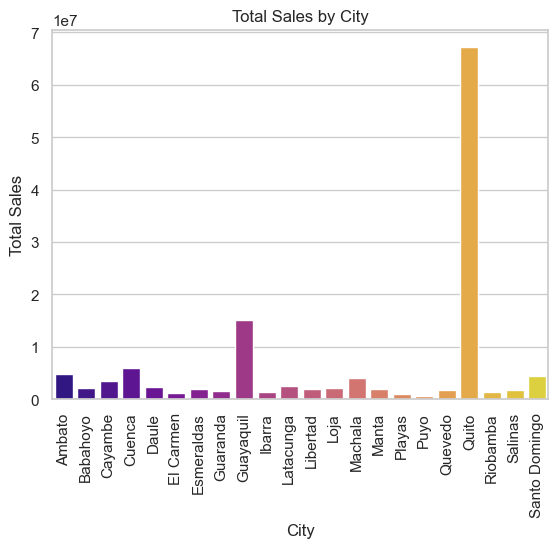

In [59]:
# Plot sales by city
# plt.subplot(2, 2, 2)
sns.barplot(data=grouped_sales_city, x='city', y='sales', palette='plasma')
plt.title('Total Sales by City')
plt.xlabel('City')
plt.ylabel('Total Sales')
plt.xticks(rotation=90)
plt.show()

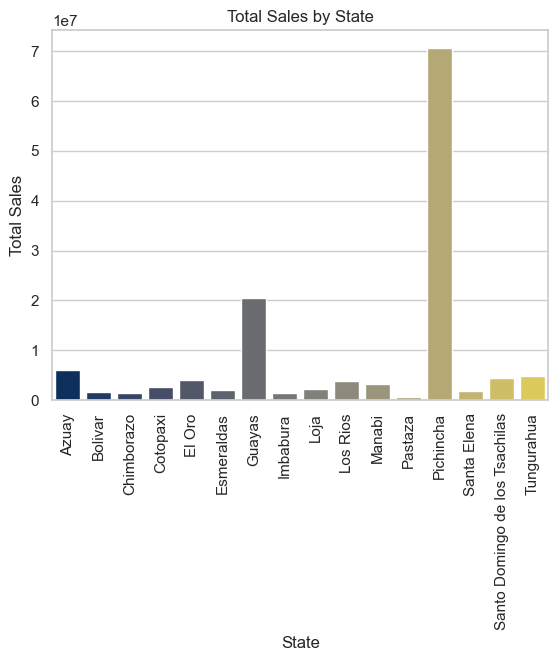

In [60]:
# Plot sales by state

sns.barplot(data=grouped_sales_state, x='state', y='sales', palette='cividis')
plt.title('Total Sales by State')
plt.xlabel('State')
plt.ylabel('Total Sales')
plt.xticks(rotation=90)
plt.show()

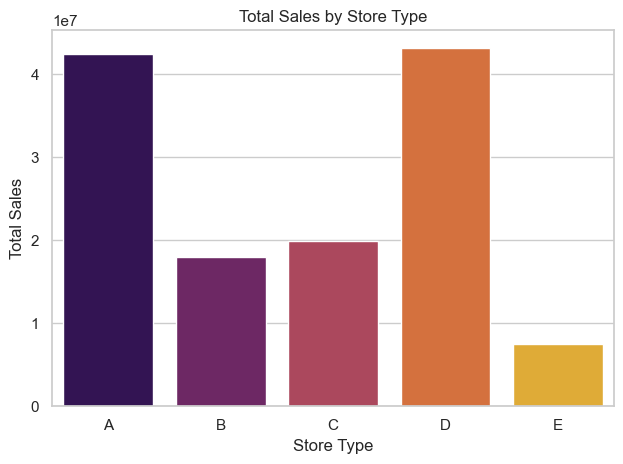

In [61]:
# Plot sales by store type

sns.barplot(data=grouped_sales_type, x='store_type', y='sales', palette='inferno')
plt.title('Total Sales by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Total Sales')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

### Are sales affected by promotions, oil prices and holidays?

Correlation between Sales and Promotions: 0.42
Correlation between Sales and Oil Prices: -0.06
Correlation between Sales and Holidays: nan


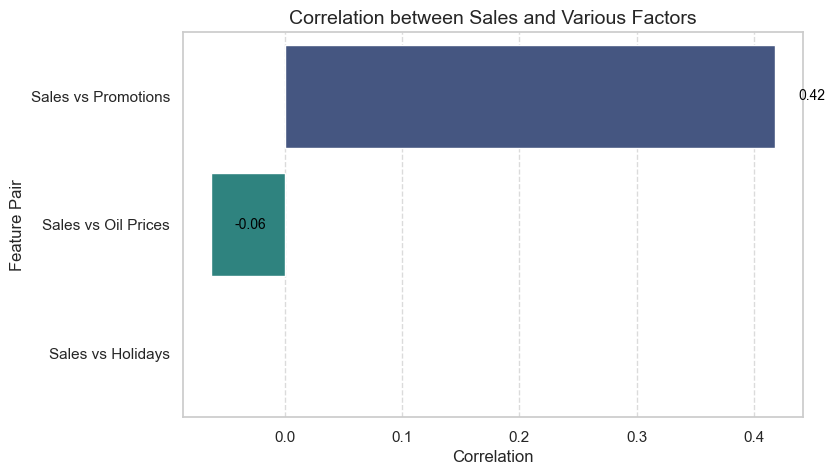

In [66]:

# Calculate correlations
corr_sales_promotions = mt4['sales'].corr(mt4['onpromotion'])
corr_sales_oil = mt4['sales'].corr(mt4['oil_price'])
corr_sales_holidays = mt4['sales'].corr(mt4['Holiday_type'].apply(lambda x: 1 if x == 'holidays' else 0))

# Print the correlation values
print(f"Correlation between Sales and Promotions: {corr_sales_promotions:.2f}")
print(f"Correlation between Sales and Oil Prices: {corr_sales_oil:.2f}")
print(f"Correlation between Sales and Holidays: {corr_sales_holidays:.2f}")

# Prepare data for plotting
labels = ['Sales vs Promotions', 'Sales vs Oil Prices', 'Sales vs Holidays']
correlations = [corr_sales_promotions, corr_sales_oil, corr_sales_holidays]

# Create a DataFrame to sort the correlations
correlation_df = pd.DataFrame({'Feature Pair': labels, 'Correlation': correlations})
correlation_df = correlation_df.sort_values(by='Correlation', ascending=False).reset_index(drop=True)

# Plot the correlations
fig, ax = plt.subplots(figsize=(8, 5))  # Reduced figure size
bars = sns.barplot(data=correlation_df, x='Correlation', y='Feature Pair', palette='viridis', orient='h', ax=ax)

# Add value annotations
for p in bars.patches:
    bars.annotate(f'{p.get_width():.2f}', (p.get_width() + 0.02, p.get_y() + p.get_height()/2),
                  ha='left', va='center', fontsize=10, color='black')

# Add titles and labels
plt.title('Correlation between Sales and Various Factors', fontsize=14)
plt.xlabel('Correlation', fontsize=12)
plt.ylabel('Feature Pair', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()


**Q6. What  analysis can we get from the date and its extractable features?**

Below 

>- 1.Seasonality Analysis: By extracting the month, quarter, or season from the date, we can analyze historical sales patterns and identify recurring seasonal trends. This information can help in predicting future sales during specific periods, such as holidays or seasonal promotions.

>- 2.Day of the Week Analysis: Extracting the day of the week can reveal sales patterns based on weekdays versus weekends. This analysis can help identify differences in customer behavior, such as higher sales on weekends or specific days when certain products or promotions perform better.

>- 3.Holiday and Event Analysis: Identifying holidays, festivals, or major events from the date can help predict sales spikes or lulls. By analyzing historical sales data during these periods, you can forecast future sales based on the impact of specific events and plan promotional strategies accordingly.

>- 4.Trend Analysis: By analyzing the sequential order of dates and sales data, you can identify overall trends and patterns. Techniques like moving averages or regression analysis can be applied to extract underlying trends and forecast future sales based on those trends.

**Q7. Which product family and stores did the promotions affect.**

In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming mt4 has columns for 'product_family', 'store', 'sales', and 'onpromotion'

# Group by product family and store to calculate average sales with and without promotions
promotion_impact = mt4.groupby(['family', 'store_type', 'onpromotion'])['sales'].mean().reset_index()

# Pivot the data to have sales with and without promotions in separate columns
promotion_pivot = promotion_impact.pivot_table(index=['family', 'store_type'], columns='onpromotion', values='sales').reset_index()
promotion_pivot.columns = ['_'.join(map(str, col)).strip() for col in promotion_pivot.columns.values]
promotion_pivot.rename(columns={'sales_0': 'Average Sales (No Promotion)', 'sales_1': 'Average Sales (Promotion)'}, inplace=True)

# Calculate the impact of promotions
promotion_pivot['Promotion Impact'] = promotion_pivot['Average Sales (Promotion)'] - promotion_pivot['Average Sales (No Promotion)']

# Sort by promotion impact
promotion_pivot_sorted = promotion_pivot.sort_values(by='Promotion Impact', ascending=False)


TypeError: 'int' object is not iterable

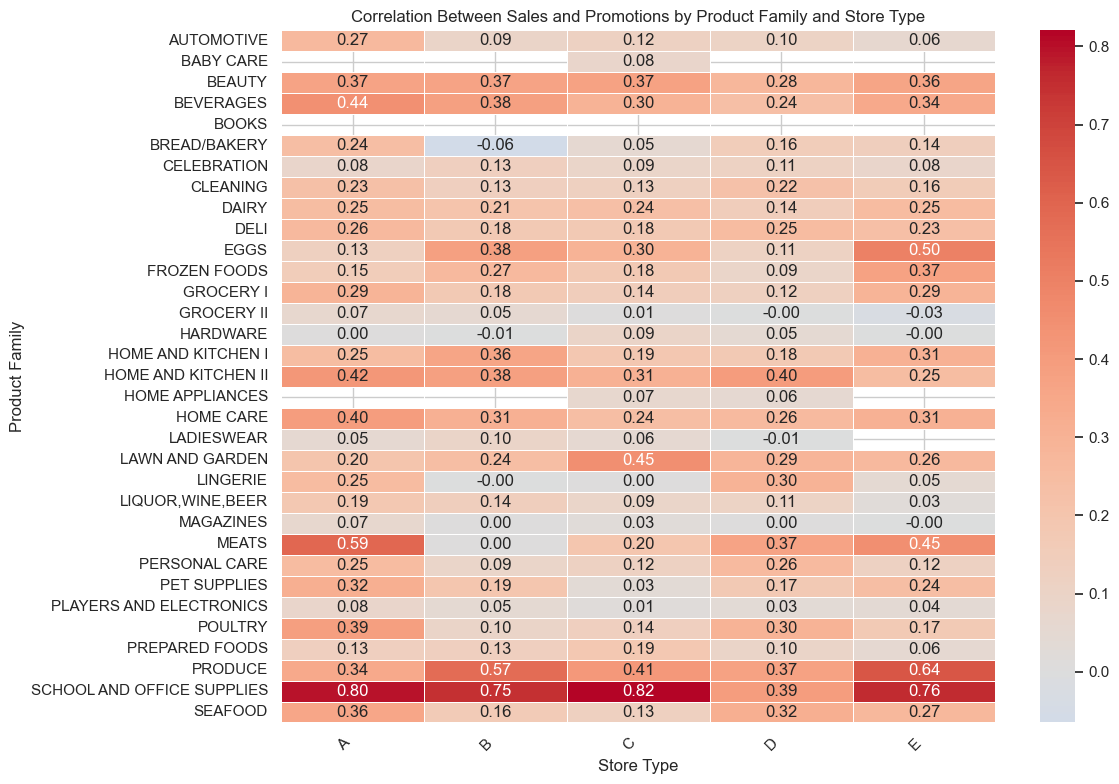

In [70]:
# Create a pivot table to calculate correlation between sales and promotions for each product family and store type
correlation_data = mt4.groupby(['family', 'store_type'])['sales'].corr(mt4['onpromotion']).unstack()

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_data, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=0.5)
plt.title('Correlation Between Sales and Promotions by Product Family and Store Type')
plt.xlabel('Store Type')
plt.ylabel('Product Family')
plt.xticks(rotation=45, ha='right')  # Rotate x labels for better readability
plt.yticks(rotation=0)  # Keep y labels horizontal
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


**Infrence**

-**School and Office Supplies:** Exhibits very strong positive correlations in store types A, B, C, and E, indicating promotions significantly boost sales in these categories
- **Meats:** Shows notable positive correlations in store types A, D, and E, suggesting promotions effectively increase sales in these stores.

- **Produce:** Strong positive correlations in store types B, C, and E, highlighting the impact of promotions on sales.

- **Beverages and Beauty, Home and Kitchen II and Home Care:** Display moderate positive correlations across most store types, indicating a reasonable impact of promotions on sales.
 
 - **Magazines,Lingerine, Books and Hardware :** Exhibits weak or negligible correlations, indicating a minimal impact of promotions on sales

 **General Observations:**

- *Promotions* tend to have a more pronounced impact on product families with frequent or seasonal demand (e.g., School and Office Supplies, Meats).
- *Store type E* shows significant positive correlations in multiple categories, indicating that promotions are particularly effective in these stores.
- *Store types A and B* also frequently show strong positive correlations, suggesting these store types benefit more from promotional activities across various product families.


**Q8. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)**

Answer
- RMSE (Root Mean Squared Error): Measures the square root of the average of the squared differences between predicted and actual values. It penalizes larger errors more than smaller ones because the errors are squared.

- MSE (Mean Squared Error): Measures the average of the squared differences between predicted and actual values. Like RMSE, it penalizes larger errors more heavily.

- MAE (Mean Absolute Error): Measures the average of the absolute differences between predicted and actual values. It is less sensitive to outliers compared to RMSE and MSE.

Why MAE Is Greater Than All
- MAE provides a linear penalty for errors, while MSE and RMSE square the errors, which makes them more sensitive to larger errors.
- If the errors are small and relatively consistent, MAE can be greater than RMSE or MSE because the latter metrics are more affected by large deviations.
- MAE does not exaggerate larger errors, so if there are a few large errors, MSE and RMSE might be smaller due to their penalization, whereas MAE remains steady.

- MAE gives a straightforward measure of average error sizewhile MSE and RMSE provide a more severe penalty for larger errors.


**Q9.  Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.** 

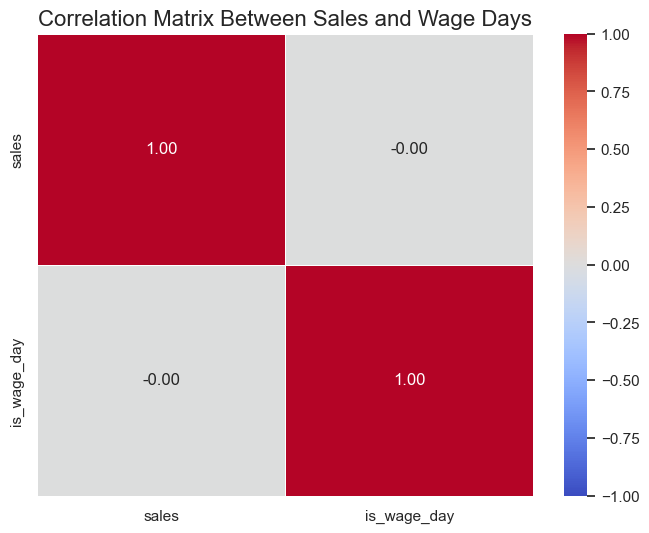

Correlation between Sales and Wage Days: -0.00


In [73]:
# Create a new column to identify if the date is the 15th or the last day of the month
mt4['day'] = mt4['date'].dt.day
mt4['last_day_of_month'] = mt4['date'] + pd.offsets.MonthEnd(0)
mt4['is_wage_day'] = mt4.apply(lambda row: 1 if row['day'] == 15 or row['date'] == row['last_day_of_month'] else 0, axis=1)

# Calculate correlation matrix
correlation_matrix = mt4[['sales', 'is_wage_day']].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Matrix Between Sales and Wage Days', fontsize=16)
plt.show()

# Print the correlation value
correlation = correlation_matrix.loc['sales', 'is_wage_day']
print(f"Correlation between Sales and Wage Days: {correlation:.2f}")


### Hypothesis 

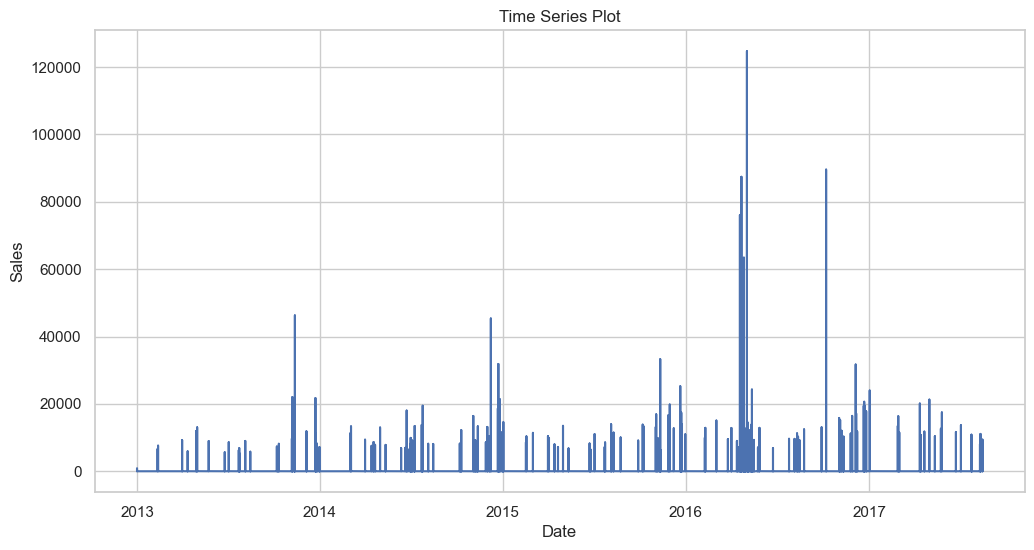

In [75]:
import matplotlib.pyplot as plt

# Assuming your time series data is in 'mt4' DataFrame with a 'date' column and 'sales' column
plt.figure(figsize=(12, 6))
plt.plot(mt4['date'], mt4['sales'])
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()


In [78]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test
result = adfuller(mt4['sales'].dropna())

# Extract p-value
p_value = result[1]

print(f"ADF Statistic: {result[0]}")
print(f"p-value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("Reject the null hypothesis argue that the time series is not stationary - Time series is stationary.")
else:
    print("Fail to reject the null hypothesis - Time series is not stationary.")


ADF Statistic: -34.96709386762333
p-value: 0.0
Reject the null hypothesis argue that the time series is not stationary - Time series is stationary.


#### Key Insights

dataset 1

- Contains 1218 rows and 2 columns 
column **dcoilwtico** has 43 missing values

**Insights into train and transaction dataset** 
- train and Transaction datasets do not contain null values or duplicates
- The timelines are between 2013-2017